In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from solardatatools import DataHandler
from solardatatools.dataio import load_redshift_data
from solardatatools.algorithms import Dilation
from spcqe.quantiles import SmoothPeriodicQuantiles
from spcqe.functions import make_basis_matrix, make_regularization_matrix

In [3]:
directory = 'fixtures'

## Basis matrix

3 periods and a trend term

In [4]:
basis_a1 = make_basis_matrix(num_harmonics=10, length=500, periods=[11, 17, 23], trend=True)
np.save(os.path.join(directory, 'basis_a1.npy'), basis_a1)

2 periods and no trend term

In [5]:
basis_a2 = make_basis_matrix(num_harmonics=10, length=400, periods=[11, 17], trend=False)
np.save(os.path.join(directory, 'basis_a2.npy'), basis_a2)

multiple harmonics and standing wave

In [6]:
basis_a3 = make_basis_matrix(num_harmonics=[3, 7], length=370, periods=[11, 3], standing_wave=[True, False], trend=False)
np.save(os.path.join(directory, 'basis_a3.npy'), basis_a3)

multiple harmonics and standing wave and max cross terms

In [7]:
basis_a4 = make_basis_matrix(num_harmonics=[4, 3], length=420, periods=[6, 8], standing_wave=True, trend=True, max_cross_k=4)
np.save(os.path.join(directory, 'basis_a4.npy'), basis_a4)

## Regularization matrix

3 periods and a trend term

In [8]:
reg_a1 = make_regularization_matrix(num_harmonics=10, weight=10, periods=[11, 17, 23], trend=True)
sp.save_npz(os.path.join(directory, 'reg_a1.npz'), reg_a1)

2 periods and no trend term

In [9]:
reg_a2 = make_regularization_matrix(num_harmonics=10, weight=1, periods=[11, 17], trend=False)
sp.save_npz(os.path.join(directory, 'reg_a2.npz'), reg_a2)

multiple harmonics and standing wave

In [10]:
reg_a3 = make_regularization_matrix(num_harmonics=[3, 7], weight=0, periods=[11, 3], standing_wave=[True, False], trend=False)
sp.save_npz(os.path.join(directory, 'reg_a3.npz'), reg_a3)

multiple harmonics and standing wave and max cross terms

In [11]:
reg_a4 = make_regularization_matrix(num_harmonics=[4, 3], weight=3, periods=[6, 8], standing_wave=True, trend=True, max_cross_k=4)
sp.save_npz(os.path.join(directory, 'reg_a4.npz'), reg_a4)

## Transforming pv data

Import

In [4]:
query = {
'siteid': "TAEHC1041562",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()


            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list: 100%|██████████████████████████████████| 7/7 [00:11<00:00,  1.62s/it]



total time: 11.34 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.88s
Cleaning                   0.09s
Filtering/Summarizing      9.36s
    Data quality           0.07s
    Clear day detect       0.13s
    Clipping detect        2.46s
    Capacity change detect 6.70s



Dilation

In [25]:
nvals_dil = 41
dil = Dilation(dh, nvals_dil=nvals_dil)
sig = dil.signal_dil
ndays = 100
sig = sig[:1 + nvals_dil * ndays]

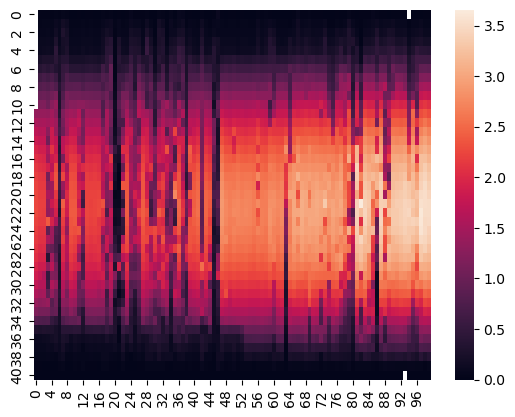

In [26]:
sns.heatmap(sig[1:].reshape(nvals_dil, len(sig) // nvals_dil, order='F'));

In [27]:
np.save(os.path.join(directory, 'pvsig.npy'), sig)

Transform

In [28]:
my_quantiles = [0.02, 0.2, 0.5, 0.8, 0.98]

In [29]:
spq1 = SmoothPeriodicQuantiles(
        num_harmonics=[8,3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=my_quantiles,
        weight=10,
        problem='sequential',
        solver='qss',
        verbose=False,
)
spq1.fit(sig)

100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


In [30]:
transformed_data1 = spq1.transform(sig)
np.save(os.path.join(directory, 'transformed_data1.npy'), transformed_data1)

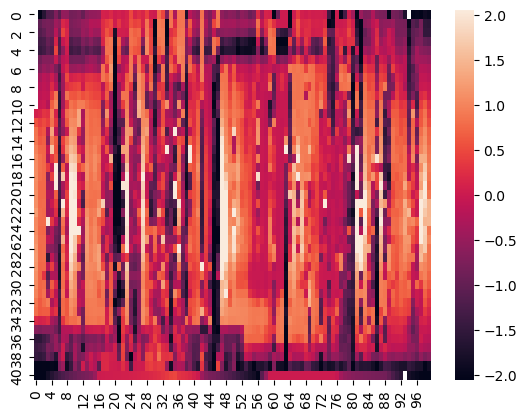

In [31]:
sns.heatmap(transformed_data1[1:].reshape(nvals_dil, len(sig) // nvals_dil, order='F'), robust=True);

In [33]:
spq2 = SmoothPeriodicQuantiles(
        num_harmonics=[8,3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=my_quantiles,
        weight=10,
        problem='full',
        solver='clarabel',
        verbose=False,
)
spq2.fit(sig)

In [34]:
transformed_data2 = spq2.transform(sig)
np.save(os.path.join(directory, 'transformed_data2.npy'), transformed_data2)

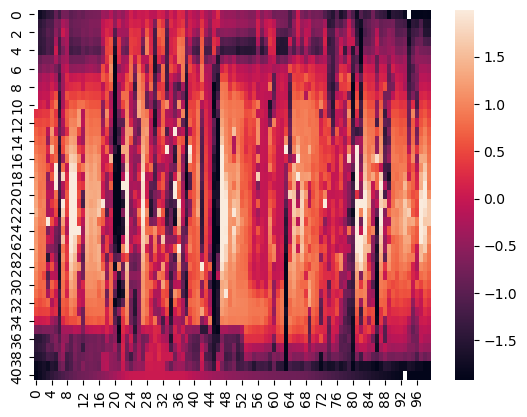

In [35]:
sns.heatmap(transformed_data2[1:].reshape(nvals_dil, len(sig) // nvals_dil, order='F'), robust = True);